# Subtask #1: Build the (directed) social graph of subreddits
- Subreddits are nodes, aggregate information about messages between two subreddits are properties of edges
- Predict sentiment for the test set posts (5K) purely based on the (heuristics on the) graph, do not use numeric descriptors of post properties

### Working on the training data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pip install node2vec

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
#df=pd.read_csv('/home/soc-redditHyperlinks-body.tsv',sep='\t')
os.chdir("/content/drive/MyDrive/Colab Notebooks/")
!ls
df = pd.read_csv("soc-redditHyperlinks-body.tsv", sep='\t')

 data2file.txt				   rating.csv
 DUMMYfinal_project_subtask2-DUMMY.ipynb   soc-redditHyperlinks-body-test.tsv
 final_project_preliminary.ipynb	   soc-redditHyperlinks-body.tsv
 final_project_subtask1.ipynb		   test.ipynb
 final_project_subtask2.ipynb		   Untitled
'Kopie von node2vec_movielens'


In [ ]:
#show the data
df_head = df.head()
print(df_head)

      SOURCE_SUBREDDIT   TARGET_SUBREDDIT  POST_ID            TIMESTAMP  \
0               israel          palestine  1x18ybs  2014-02-04 16:09:28   
1             vertcoin     cryptocurrency  1x19ums  2014-02-04 16:29:31   
2                nofap  explainlikeimfive  1x1a2ws  2014-02-04 16:31:58   
3  explainlikeimcalvin               pics  1x1amgs  2014-02-04 16:56:14   
4               aneros         askgaybros  1x1ax9s  2014-02-04 05:50:03   

   LINK_SENTIMENT                                         PROPERTIES  
0               1  386.0,346.0,0.782383419689,0.00518134715026,0....  
1               1  2980.0,2651.0,0.718456375839,0.0345637583893,0...  
2               1  692.0,589.0,0.796242774566,0.00578034682081,0....  
3               1  111.0,106.0,0.747747747748,0.036036036036,0.04...  
4               1  2312.0,1907.0,0.766868512111,0.00562283737024,...  


In [ ]:
#select distinct columns
df_select = df[["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT", "LINK_SENTIMENT"]]
df_select

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT
0,israel,palestine,1
1,vertcoin,cryptocurrency,1
2,nofap,explainlikeimfive,1
3,explainlikeimcalvin,pics,1
4,aneros,askgaybros,1
...,...,...,...
281557,negareddit,debatefascism,1
281558,mildlynomil,justnomil,1
281559,mmorpg,blackdesertonline,1
281560,electricskateboards,askreddit,1


In [ ]:
#check for 0-values
df.isnull().values.any()

False

In [ ]:
#remove unwanted columns
df_drop = df.drop(labels = ['POST_ID', 'TIMESTAMP', 'PROPERTIES'], axis = 1, inplace = True)

In [ ]:
#select a smaller part of the data only
df = df[:50000]

In [ ]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT
0,israel,palestine,1
1,vertcoin,cryptocurrency,1
2,nofap,explainlikeimfive,1
3,explainlikeimcalvin,pics,1
4,aneros,askgaybros,1
...,...,...,...
49995,buildapc,buildapcforme,1
49996,asianbeautyexchange,makeupexchange,1
49997,ideasfortheadmins,leagueoflegends,1
49998,clg,leagueoflegends,-1


In [ ]:
#distinguish between positive and negative
def sentiments(score):
    if score < 0:
        return "negative"
    else:
        return "positive"
df["RATING"] = df["LINK_SENTIMENT"].apply(sentiments)
df.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT,RATING
0,israel,palestine,1,positive
1,vertcoin,cryptocurrency,1,positive
2,nofap,explainlikeimfive,1,positive
3,explainlikeimcalvin,pics,1,positive
4,aneros,askgaybros,1,positive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

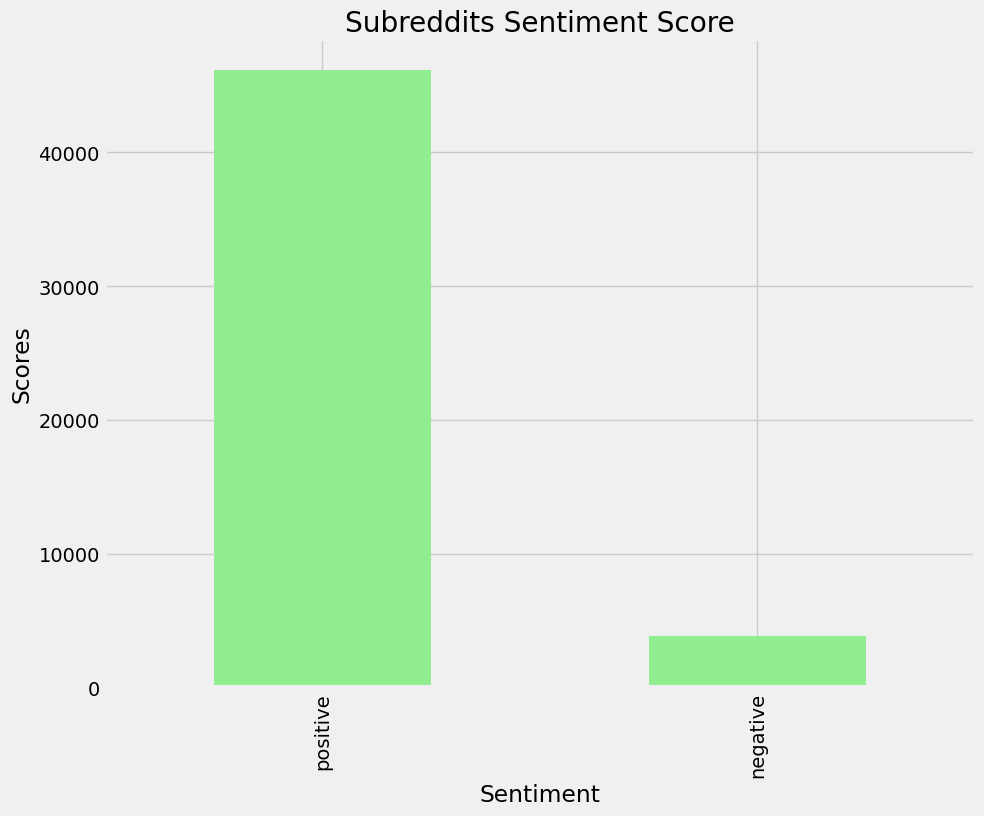

In [ ]:
#plot the sentiment scores
plt.title("Subreddits Sentiment Score")
plt.xlabel("Sentiment")
plt.ylabel("Scores")
plt.rcParams["figure.figsize"] = (10,8)
df["RATING"].value_counts().plot(kind="bar", color="lightgreen")
plt.show()

In [ ]:
#remove unwanted lables
df_drop = df.drop(labels = ['LINK_SENTIMENT'], axis = 1, inplace = True)

In [ ]:
#save to csv
#df.to_csv("rating.csv")

In [ ]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,RATING
0,israel,palestine,positive
1,vertcoin,cryptocurrency,positive
2,nofap,explainlikeimfive,positive
3,explainlikeimcalvin,pics,positive
4,aneros,askgaybros,positive
...,...,...,...
49995,buildapc,buildapcforme,positive
49996,asianbeautyexchange,makeupexchange,positive
49997,ideasfortheadmins,leagueoflegends,positive
49998,clg,leagueoflegends,negative


In [ ]:
#code for the directed graph
"""import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec

# Sample data in DataFrame



# Create a directed graph
graph = nx.DiGraph()

# Add nodes (subreddits) to the graph
source_nodes = df['SOURCE_SUBREDDIT'].tolist()
target_nodes = df['TARGET_SUBREDDIT'].tolist()
nodes = set(source_nodes + target_nodes)
graph.add_nodes_from(nodes)

# Add edges (links between subreddits) with their properties
for index, row in df.iterrows():
    source = row['SOURCE_SUBREDDIT']
    target = row['TARGET_SUBREDDIT']
    link_sentiment = row['RATING']
    graph.add_edge(source, target, link_sentiment=link_sentiment)

# Visualize the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(graph, seed=42)
nx.draw_networkx(graph, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=12)

# Draw edges as lines without edge labels (properties)
edges = nx.draw_networkx_edges(graph, pos, arrows=False, edge_color='gray', alpha=0.5)

plt.title("Directed Graph of Subreddits")
plt.show()
"""

'import pandas as pd\nimport networkx as nx\nimport matplotlib.pyplot as plt\nfrom node2vec import Node2Vec\n\n# Sample data in DataFrame\n\n\n\n# Create a directed graph\ngraph = nx.DiGraph()\n\n# Add nodes (subreddits) to the graph\nsource_nodes = df[\'SOURCE_SUBREDDIT\'].tolist()\ntarget_nodes = df[\'TARGET_SUBREDDIT\'].tolist()\nnodes = set(source_nodes + target_nodes)\ngraph.add_nodes_from(nodes)\n\n# Add edges (links between subreddits) with their properties\nfor index, row in df.iterrows():\n    source = row[\'SOURCE_SUBREDDIT\']\n    target = row[\'TARGET_SUBREDDIT\']\n    link_sentiment = row[\'RATING\']\n    graph.add_edge(source, target, link_sentiment=link_sentiment)\n\n# Visualize the graph\nplt.figure(figsize=(10, 6))\npos = nx.spring_layout(graph, seed=42)\nnx.draw_networkx(graph, pos, with_labels=True, node_size=1500, node_color=\'skyblue\', font_size=10, font_weight=\'bold\', arrowsize=12)\n\n# Draw edges as lines without edge labels (properties)\nedges = nx.draw_netwo

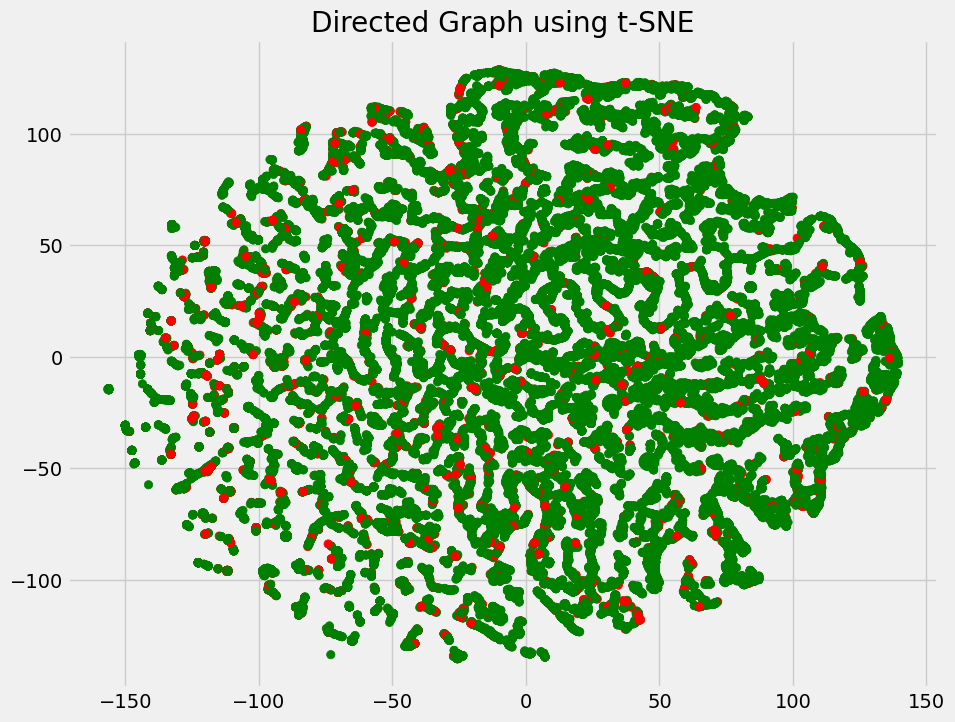

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#create new column with the values of the subreddits
df["SUBREDDIT_ID"] = pd.factorize(df["SOURCE_SUBREDDIT"])[0]
df["TARGET_SUBREDDIT_ID"] = pd.factorize(df["TARGET_SUBREDDIT"])[0]

#do the t-SNE embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(df[["SUBREDDIT_ID", "TARGET_SUBREDDIT_ID"]].values)

#plot embedding
plt.scatter(embedding[:, 0], embedding[:, 1], c=df["RATING"].map({"positive": "green", "negative": "red"}))
plt.title("Directed Graph using t-SNE")
plt.show()


### Working on the test data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import pandas as pd

#df=pd.read_csv('/home/soc-redditHyperlinks-body.tsv',sep='\t') #use for linux
os.chdir("/content/drive/MyDrive/Colab Notebooks/")
!ls
df = pd.read_csv("soc-redditHyperlinks-body-test.tsv", sep='\t')

 data2file.txt				   rating.csv
 DUMMYfinal_project_subtask2-DUMMY.ipynb   soc-redditHyperlinks-body-test.tsv
 final_project_preliminary.ipynb	   soc-redditHyperlinks-body.tsv
 final_project_subtask1.ipynb		   test.ipynb
 final_project_subtask2.ipynb		   Untitled
'Kopie von node2vec_movielens'


In [9]:
#remove unwanted lables
df_drop = df.drop(labels = ['POST_ID', 'TIMESTAMP', 'PROPERTIES'], axis = 1, inplace = True)

In [6]:
#df = df[:1000] #for a short view only

In [10]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT
0,gaming4gamers,fallout,1
1,kpop,dota2,1
2,airsoft,airsoftmarket,1
3,circlebroke,childfree,1
4,tribes,games,1
...,...,...,...
4994,science,everythingscience,1
4995,atlantahawks,nba,1
4996,omaha,lfg,1
4997,fantasymltp,tagpro,1


In [11]:
#distinguish between positive and negative
def sentiments(score):
    if score < 0:
        return "negative"
    else:
        return "positive"
df["RATING"] = df["LINK_SENTIMENT"].apply(sentiments)
df.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT,RATING
0,gaming4gamers,fallout,1,positive
1,kpop,dota2,1,positive
2,airsoft,airsoftmarket,1,positive
3,circlebroke,childfree,1,positive
4,tribes,games,1,positive


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

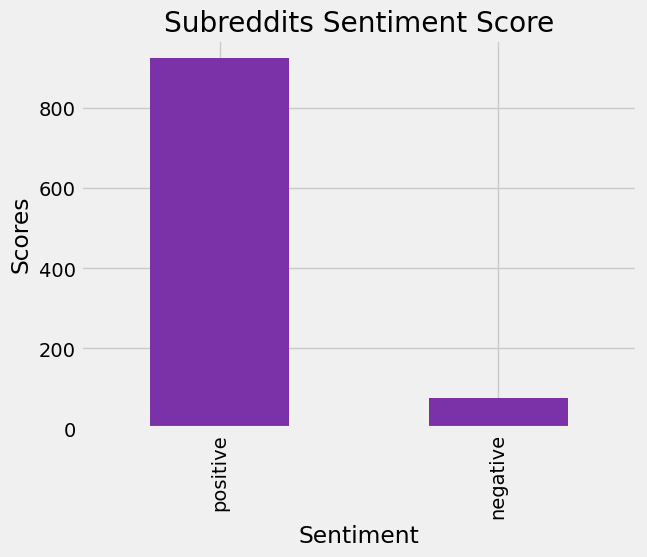

In [ ]:
#plot the sentiment scores
plt.title("Subreddits Sentiment Score")
plt.xlabel("Sentiment")
plt.ylabel("Scores")
plt.rcParams["figure.figsize"] = (10,8)
df["RATING"].value_counts().plot(kind="bar", color="#7b32a8")
plt.show()

In [13]:
#remove unwanted lables
df_drop = df.drop(labels = ['LINK_SENTIMENT'], axis = 1, inplace = True)

In [14]:
df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,RATING
0,gaming4gamers,fallout,positive
1,kpop,dota2,positive
2,airsoft,airsoftmarket,positive
3,circlebroke,childfree,positive
4,tribes,games,positive
...,...,...,...
4994,science,everythingscience,positive
4995,atlantahawks,nba,positive
4996,omaha,lfg,positive
4997,fantasymltp,tagpro,positive


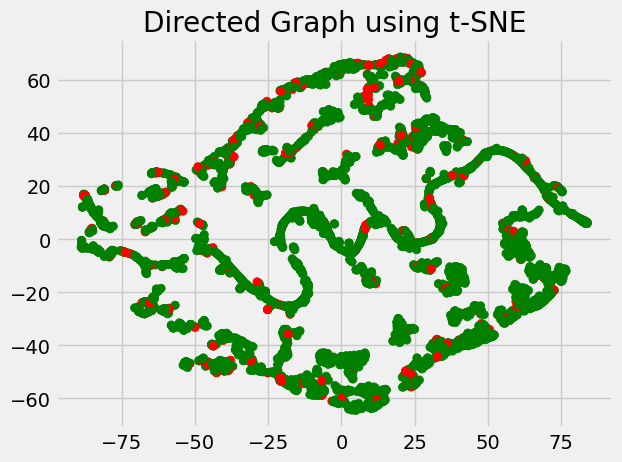

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#create new column with the values of the subreddits
df["SUBREDDIT_ID"] = pd.factorize(df["SOURCE_SUBREDDIT"])[0]
df["TARGET_SUBREDDIT_ID"] = pd.factorize(df["TARGET_SUBREDDIT"])[0]

#do the t-SNE embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(df[["SUBREDDIT_ID", "TARGET_SUBREDDIT_ID"]].values)

#plot embedding
plt.scatter(embedding[:, 0], embedding[:, 1], c=df["RATING"].map({"positive": "green", "negative": "red"}))
plt.title("Directed Graph using t-SNE")
plt.show()


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression


#create a new column with the values of the subreddits
df["SUBREDDIT_ID"] = pd.factorize(df["SOURCE_SUBREDDIT"])[0]
df["TARGET_SUBREDDIT_ID"] = pd.factorize(df["TARGET_SUBREDDIT"])[0]

#make the t-SNE embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(df[["SUBREDDIT_ID", "TARGET_SUBREDDIT_ID"]].values)

#define the target variable
target = df["RATING"]

#create the model
model = LogisticRegression()

#fit the model
model.fit(embedding, target)

#make a prediction for a new data point (e.g., new_subreddit = np.array([1, 2]))
#dp = data point
dp1 = int(input("Enter the first data point..."))
dp2 = int(input("Enter the second data point..."))
new_subreddit = np.array([[dp1, dp2]])
prediction = model.predict(new_subreddit)

#print the prediction
print(prediction)


Enter the first data point...3
Enter the second data point...4
['positive']
